# <font  color = "#0093AF">R$_{1ρ}$ relaxation</font>
Measurement of $R_{1\rho}$ in solid-state NMR is a powerful means of characterizing μs to ms dynamics.$^{1-3}$ We may simulate it as the result of stochastic reorientation of anisotropic tensors, such as dipole and chemical shift anisotropies.

[1] P. Ma, J.D. Haller, J. Zajakala, P. Macek, A.C. Sivertsen, D. Willbold, J. Boisbouvier, P. Schanda. [*Angew. Chem. Int. Ed.*](https://doi.org/10.1002/anie.201311275), **2014**, 53, 4312-4317.

[2] J.R. Lewandowki, M.E. Halse, M. Blackledge, L. Emsley. [*Science*](https://doi.org/10.1126/science.aaa6111), **2015**, 348, 578.

[3] A.A. Smith, E. Testori, R. Cadalbert, B.H. Meier, M. Ernst. [*J. Biomol. NMR*](https://doi.org/10.1007/s10858-016-0047-8), **2016**, 65, 171-191.

<a href="https://githubtocolab.com/alsinmr/SLEEPY_tutorial/blob/main/ColabNotebooks/Chapter3/Ch3_R1p.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg"></a>

## Setup

In [2]:
import SLEEPY as sl
import numpy as np
import matplotlib.pyplot as plt

## Build the system
We build an H–N system, with dipole coupling and $^{15}$N CSA. The system is constructed before (`ex0`) and after (`ex1`) a 25$^\circ$ hop.

In [3]:
delta=sl.Tools.dipole_coupling(.102,'1H','15N')
ex0=sl.ExpSys(v0H=600,Nucs=['15N','1H'],vr=60000,LF=False)
ex0.set_inter('dipole',i0=0,i1=1,delta=delta)
# The 15N CSA is oriented about 23 degrees away from the H–N bond
ex0.set_inter('CSA',i=0,delta=113,euler_d=[0,23,0])
phi=25 #25 degree hop
ex1=ex0.copy()
ex1.set_inter('dipole',i0=0,i1=1,delta=delta,euler_d=[0,phi,0])
# We want the same hop amplitude on both interactions
_=ex1.set_inter('CSA',i=0,delta=113,euler_d=[[0,23,0],[0,phi,0]])

L=sl.Liouvillian(ex0,ex1,kex=sl.Tools.twoSite_kex(3e-7))

# Sequence with 45 kHz spin-lock
seq=L.Sequence().add_channel('15N',v1=45e3)

rho=sl.Rho('15Nx','15Nx')

### View the tensors
Below, we view the CSA before and after the hop, using the `ex.plot_inter()` function.

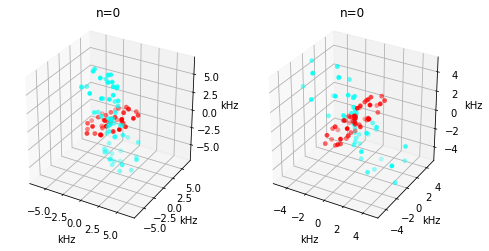

In [4]:
fig=plt.figure(figsize=[8,4])
ax=[fig.add_subplot(1,2,k+1,projection='3d') for k in range(2)]
ex0.plot_inter(-1,ax=ax[0])
_=ex1.plot_inter(-1,ax=ax[1])

### Run the sequence and plot
We run the sequence, and plot the results.

In [5]:
_=rho.DetProp(seq,n=6000)

State-space reduction: 32->16


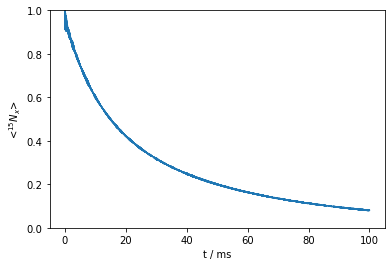

In [6]:
ax=rho.plot()
_=ax.set_ylim([0,1])

### Origin of multi-exponentiality
Note that the signal decay is multi-exponential. This is always the case in solid-state NMR, where different orientations give rise to different decay rates. However, this curve is particularly multiexponential, due to TROSY-like effects resulting from relaxation due to both the dipole and CSA (see [TROSY](../Chapter2/Ch2_TROSY.ipynb) in chapter 2).

We may investigate this by actively separating components when the $^1$H is in the α and β states. Here, we must construct our detection operators explicitly from the spin-matrices found in `ex0.Op`.

In [ ]:
rho=sl.Rho('15Nx',[ex0.Op[0].x@ex0.Op[1].alpha,ex0.Op[0].x@ex0.Op[1].beta])
rho.DetProp(seq,n=6000)
ax=rho.plot()
_=ax.legend((r'H$^\alpha$',r'H$^\beta$'))

State-space reduction: 32->16


Indeed, we see two very different decay curves, corresponding to the two different components. However, this is somewhat unrealistic in solid-state NMR, where $^1$H spin-diffusion periodically inverts the $^1$H spins. We may add this effect by flipping the $^1$H with a rate of 50 s$^{-1}$, to see how the two curves re-converge. Here, we plot the average curve plus the two $^1$H states separately.

State-space reduction: 32->16


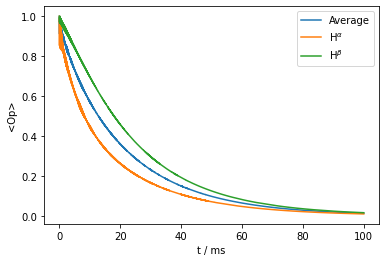

In [8]:
L.add_relax('SpinDiffusion',i=1,k=50)

rho=sl.Rho('15Nx',['15Nx',ex0.Op[0].x@ex0.Op[1].alpha,ex0.Op[0].x@ex0.Op[1].beta])
rho.DetProp(seq,n=6000)
ax=rho.plot()
_=ax.legend(('Average',r'H$^\alpha$',r'H$^\beta$'))

### Field-strength dependence
We may also observe how the decay rates depend on the applied field strength. Below, we apply field strengths of 10, 20, 30, 40, and 50 kHz, where we expect faster relaxation as we get closer to the MAS frequency (60 kHz).

In [9]:
rho=[]
for v1 in np.linspace(10e3,50e3,4):
    rho.append(sl.Rho('15Nx','15Nx'))
    seq.add_channel('15N',v1=v1)
    rho[-1].DetProp(seq,n=6000)

State-space reduction: 32->16
State-space reduction: 32->16
State-space reduction: 32->16
State-space reduction: 32->16


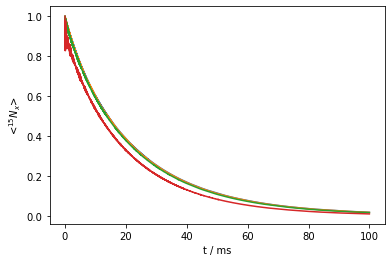

In [10]:
ax=plt.subplots()[1]
for rho0 in rho:rho0.plot(ax=ax)

The curves are fairly similar, indicating a relatively fast motion (300 ns was input). We may slow down this motion to obtain faster relaxation, but also more dispersion among the curves.

In [11]:
L.kex=sl.Tools.twoSite_kex(1e-5)
rho=[]
for v1 in np.linspace(10e3,50e3,4):
    rho.append(sl.Rho('15Nx','15Nx'))
    seq.add_channel('15N',v1=v1)
    rho[-1].DetProp(seq,n=1000)

State-space reduction: 32->16
State-space reduction: 32->16
State-space reduction: 32->16
State-space reduction: 32->16


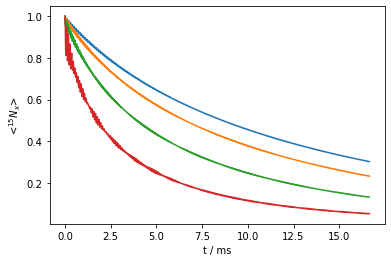

In [12]:
ax=plt.subplots()[1]
for rho0 in rho:rho0.plot(ax=ax)

We may also investigate correlation time dependence for several field strengths. In this case, we use a special feature of SLEEPY, the `rho.extract_decay_rates(...)` function, which extracts non-oscillating terms from the propagator or sequence directly, without actually propagating the system. This is achieved by finding the eigenvalues and eigenvectors of the propagator. The real parts of the logarithm of the eigenvalues yield the decay rates, where we may filter for non-oscillating terms by finding eigenvalues that are strictly real.

Note that various modes for this function exist, yielding different averaging and different weightings. Type `help(rho.extract_decay_rates)` for more details.

This mode of the function only works where oscillating terms should be neglected (so, for example, we cannot get $T_2$ this way, because peaks in a spectrum both oscillate and decay).

In [4]:
# ~ 10 minutes calculation time (164 simulations with powder average)
from time import time
sl.Defaults['verbose']=False
tc0=np.logspace(-8,-4,41)
v10=[10e3,25e3,40e3,50e3]
R1p={v1:np.zeros(tc0.shape) for v1 in v10}
rho=sl.Rho('15Nx','15Nx')

t0=time()
for k,tc in enumerate(tc0):
    L.kex=sl.Tools.twoSite_kex(tc=tc)
    for v1 in v10:
        seq.add_channel('15N',v1=v1)
        R1p[v1][k]=rho.extract_decay_rates(seq)
    if np.mod(k,10)==0:
        print(f'log10(tc)={np.log10(tc):.1f}, {time()-t0:.0f} seconds elapsed')

log10(tc)=-8.0, 14 seconds elapsed
log10(tc)=-7.0, 153 seconds elapsed
log10(tc)=-6.0, 272 seconds elapsed
log10(tc)=-5.0, 385 seconds elapsed
log10(tc)=-4.0, 540 seconds elapsed


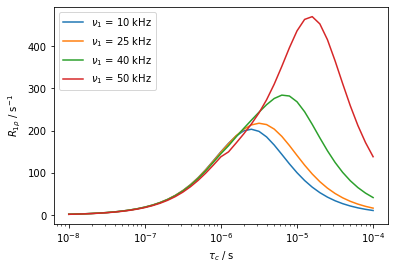

In [5]:
ax=plt.subplots()[1]
for v1 in v10:
    ax.semilogx(tc0,R1p[v1],label=fr'$\nu_1$ = {v1/1e3:.0f} kHz')
ax.legend()
ax.set_xlabel(r'$\tau_c$ / s')
_=ax.set_ylabel(r'$R_{1\rho}$ / s$^{-1}$')

## Combined decay from reorientation and chemical shift modulation

It is also possible that we have both reorientational motion *and* chemical shift modulation, induced by the same motion. To investigate this the results, we add chemical shifts to the $^{15}$N, and observe the field-strength dependence of the relaxation.

In [16]:
ex0.set_inter('CS',i=0,ppm=-5)
ex1.set_inter('CS',i=0,ppm=5)

L=sl.Liouvillian(ex0,ex1,kex=sl.Tools.twoSite_kex(tc=1e-4))
seq=L.Sequence()
rho=sl.Rho('15Nx','15Nx')

R1p=[]
v10=np.linspace(1,51,21)*1e3
for v1 in v10:
    seq.add_channel('15N',v1=v1)
    R1p.append(rho.extract_decay_rates(seq,mode='pwdavg'))

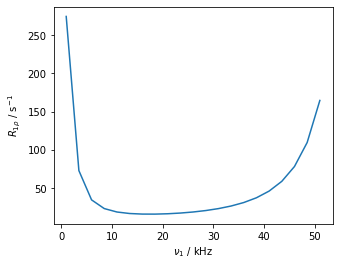

In [17]:
ax=plt.subplots(figsize=[5,4])[1]
ax.plot(v10/1e3,R1p)
ax.set_xlabel(r'$\nu_1$ / kHz')
_=ax.set_ylabel(r'$R_{1\rho}$ / s$^{-1}$')

We see increased relaxation rate constants at low RF-fields, due to chemical shift modulation, and at high RF-fields due to reorientational motion of the $^{15}$N CSA and H–N dipole coupling. Note that the timescale dependence of the two relaxation mechanisms is different. This experiment is particularly interesting because while being essentially the same experiment, we investigate two different mechanisms of relaxation just based on the field-strength setting.$^{4-5}$

[4] J.D. Haller, P. Schanda. [*J. Biomol. NMR*](https://doi.org/10.1007/s10858-013-9787-x), **2013**, 57, 263-280.

[5] P. Rovó. [*Solid-State NMR*](https://doi.org/10.1016/j.ssnmr.2020.101665), **2020**, 108, 101665.